# Train the GAN

In [1]:
import tensorflow as tf
tf.__version__
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
from IPython.display import clear_output

from IPython import display

2023-11-06 10:15:06.849130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 10:15:06.978884: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 10:15:07.536457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-11-06 10:15:07.536527: W tensorflow/comp

## Load Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# n1= 93 n2=401 n3=401 d1=d2=d3=50m
vel = readbin('../dataset/overthrust.bin',93,401*401)
# vel = np.round(vel / 100) * 100 # Quantize image (Smaller image depth)
vel = np.reshape(vel,[93,401,401])
n = 120
vel = vel[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape

    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])

    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 8), dpi=300)
for i in range(72):
  plt.subplot(12, 6, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/overthrust.bin'

## Normalize images

In [9]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 32
dim_z=100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-0.99999994 0.99999994


## Define Generator and Discriminator

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

kernal_size = (5, 5)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs, loss_history = []):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      loss = train_step(image_batch)
    loss_history.append(loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             loss_history)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           loss_history)
  return loss_history

def generate_and_save_images(model, epoch, test_input, loss_history):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 4),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  # plt.savefig('./dcgan/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


  plt.figure(figsize=(8, 4),dpi=100)
  plt.title('Training History')
  plt.plot(loss_history)
  plt.legend(['Generator loss', 'Discriminator loss'])
  plt.show()

## Train the model

tf.Tensor([[0.00077047]], shape=(1, 1), dtype=float32)


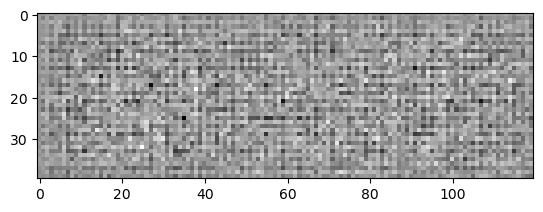

In [11]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

checkpoint_dir = './dcgan/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50000
noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

global loss_history
restore = 1
training = 0
if restore==1: 
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:  loss_history = []
if training==1: train(train_dataset, EPOCHS)

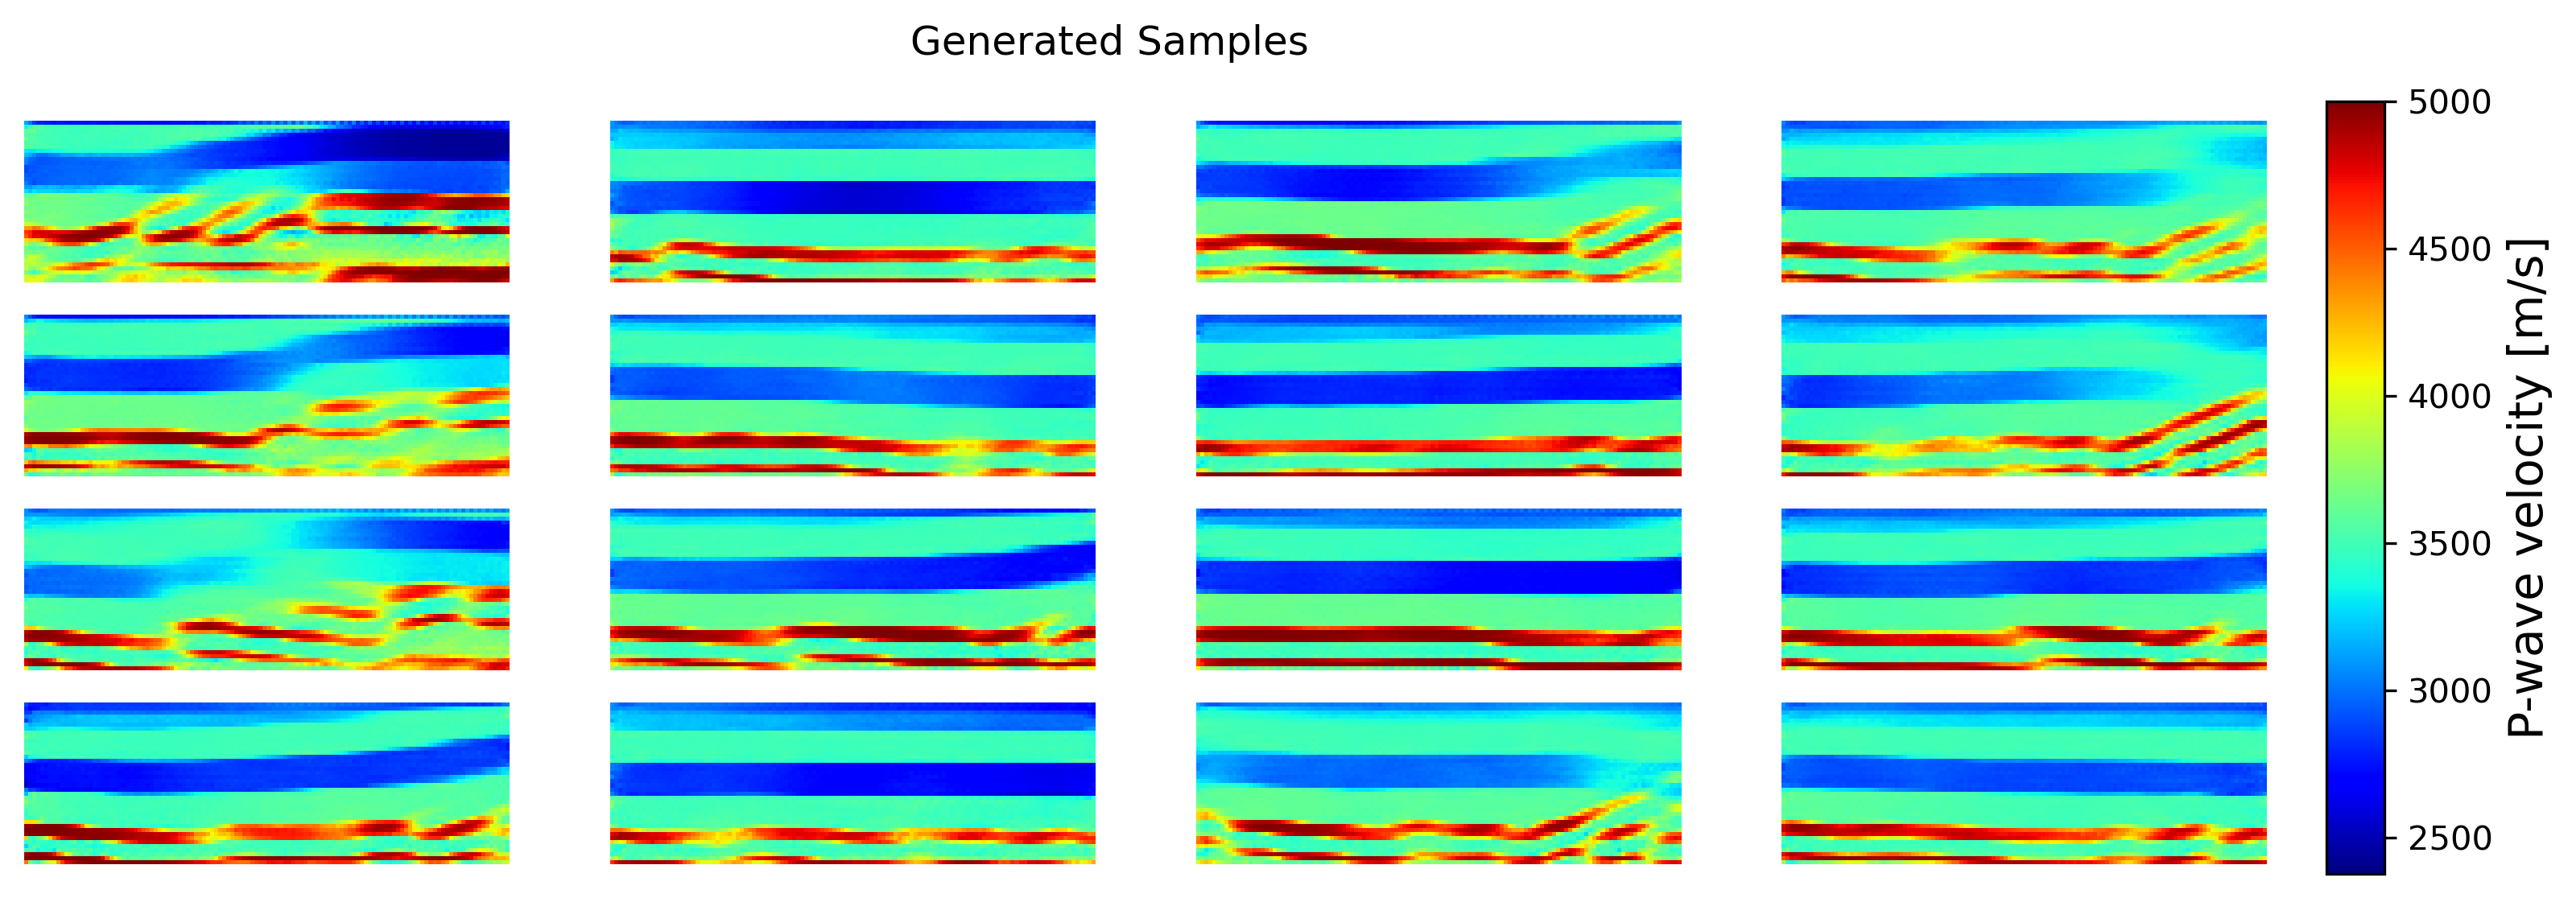

In [12]:
noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
fig = plt.figure(figsize=(12, 4),dpi=300)
plt.suptitle("Generated Samples")
for i in range(num_examples_to_generate):
  plt.subplot(4, 4, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
plt.show()

# Forward Modeling

## Functions

In [13]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from IPython.display import clear_output
import numpy as np
import cupy as cp
import cupyx
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model
from func.velocity_model import gaussian2d
from joblib import Parallel, delayed

precision = np.float64
device = 'cpu'


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()

def prop2d_cpu(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = np.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')

		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs

def second_order_derivative_cpu(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = np.concatenate([np.zeros((nz*nx, 1)), p_dt_dt, np.zeros((nz*nx, 1))], axis=1)

	return p_dt_dt

def prop2d(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = cp.array([wsrc]) if wsrc.ndim == 1 else cp.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = cp.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = cp.array(vele.flatten())

		# Center Part (Laplacian)
		mask0 = cp.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = cp.zeros(size)
		off_diagonal_x_left = cp.zeros(size)
		off_diagonal_x_right = cp.zeros(size)
		off_diagonal_z_left = cp.zeros(size)
		off_diagonal_z_right = cp.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*cp.ones(size) + fact*(-2*cp.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*cp.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*cp.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*cp.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = cp.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = cp.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = cp.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = cp.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		# A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
		# 						[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		A = cupyx.scipy.sparse.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		# Wavefield p mask (initial center part)
		maskp = cp.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = cp.zeros(size) # Previous wave field
		pt = cp.zeros(size)
		pp = cp.zeros(size)

		p = [cp.zeros(nz*nx)]
		p.append(cp.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = cp.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = cp.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = cp.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = cp.moveaxis(cp.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return cp.asnumpy(p), cp.asnumpy(d_obs)

def second_order_derivative(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p = cp.array(p)
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = cp.concatenate([cp.zeros((nz*nx, 1)), p_dt_dt, cp.zeros((nz*nx, 1))], axis=1)

	return cp.asnumpy(p_dt_dt)

def gradient_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	nsrc = zxsrc.shape[1]
	grads = np.zeros_like(vel)
	for i in range(nsrc):
		# print('Source', i, end='...   ')
		zxsrci = np.expand_dims(zxsrc[:,i],-1)
		p_fwd, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
		residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
		# Calculate back propagated p_back(z,x,t)
		p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrci, vel, at, az, ax, next, device)
		p_back = np.flip(p_back,axis=1)
		# Calculate second order time derivative of p_fwd(z,x,t)
		p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
		# Calculate gradiant
		grad = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
		grads += grad

	return grads.flatten()

def J_multi(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
    nsrc = zxsrc.shape[1]
    Js = 0
    for i in range(nsrc):
        zxsrci = np.expand_dims(zxsrc[:,i],-1)
        nz, nx = len(az), len(ax)
        if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
        _, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
        residual = d - d_obs[i]
        J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
        Js += J

    # print("J = %.2f" % Js)
    global loss
    loss = Js.copy()

    return Js

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

def disp_fwd(vel, d_obs):
	plt.figure(figsize=(10,3), dpi=300)
	plt.subplot(1,2,1) 
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	plt.imshow(tf.transpose(d_obs[0]),cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()

## Propagation

In [14]:

# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,400
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

## Choose a true velocity field
## Read the original input data
# vel   = readbin('../dataset/marm2_sel.dat',nz,nx)[1:,1:]
# vel = vel[::5,::5]
# v_ref = vel * 1e3

# v_ref = cropped_images[860,:,:,0].numpy()
# v_ref = cropped_images[530,:,:,0].numpy()

seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
Gz_i = inverse_norm(Gz[0,:,:,0],vmin,vmax)
v_ref = Gz_i.numpy().flatten()
mu=0

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# vmin,vmax = v_ref.min(),v_ref.max()

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.arange(0,nx)
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
# zxsrc = np.array([[1], [3*nx//6]])
nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next)
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

Min velocity: 2771.12  Max velocity 4957.37
dz,dx,dt (m): 9.504880859375 9.504880859375 0.0012094673270528794
Model dimension [nz,nx,nt]:  40 120 400


CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

# Conditional Generator

## Clone pre-trained generator

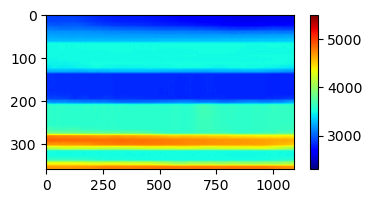

In [21]:
# Clone pre-trained generator
cond_generator = tf.keras.models.clone_model(generator)  # Clone generator
cond_generator.set_weights(generator.get_weights()) # Clone weights
# print(conditional_generator.summary())

loss_tracker = []
BATCH_SIZE = 32
noise_batch = tf.random.normal([BATCH_SIZE, dim_z])

epoch_vels = []
for j in range(BATCH_SIZE):
      # Generate a new image
      seed = noise_batch[j:j+1,:]
      Gz = cond_generator(seed, training=False)
      Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
      vel = tf.reshape(Gz, -1)
      epoch_vels.append(vel)
v_init = tf.reduce_mean(epoch_vels,axis=0)

plt.figure(figsize=(4,2),dpi=100)
plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
plt.colorbar()

## Create Inference network I

In [22]:
# Clone pre-trained generator
cond_generator = tf.keras.models.clone_model(generator)  # Clone generator
cond_generator.set_weights(generator.get_weights()) # Clone weights

# Define the dimensionality of the Inference and Latent Gaussian distributions
dim_w = dim_z

# Create the inference network I
def make_inference_model():
    model = tf.keras.Sequential()
    
    # Fully connected layer with SeLU activation
    model.add(layers.Dense(512, activation='selu', input_shape=(dim_w,)))
    
    # Additional fully connected layers with SeLU activations
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dense(512, activation='selu'))
    
    # Output layer mapping to dim_z
    model.add(layers.Dense(dim_w))
    
    return model


@tf.custom_gradient
def dJ_dm(vel):
    loss_J = J_multi(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,'cpu')
    loss_J = tf.cast(loss_J, tf.float32)

    def grad_fn(upstream):
        grad = gradient_multi(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,'cpu')
        return upstream * tf.cast(grad, tf.float32)
    return loss_J, grad_fn


# Create an instance of the inference network I
inference_network = make_inference_model()

# Generate a random 100-dimensional Gaussian sample as input
input_sample = tf.random.normal([32, dim_w])

# Pass the input through the inference network
output_sample = inference_network(input_sample, training=False)

# Check the shape of the output sample (it should be [1, dim_z])
print("Output sample shape:", output_sample.shape)

BATCH_SIZE = 64
loss_tracker = []
sigma = 1e-2  # Noise level
epoch_vels = []

# Compute initial mean velocity
for _ in range(BATCH_SIZE):
    print('.',end='')
    # Sample from w distribution
    noise_w = tf.random.normal([1, dim_w])
    # Pass noise through Inference Network I
    noise_z = inference_network(noise_w, training=False)
    # Generate image from I(w)
    Gz = cond_generator(noise_z, training=False)
    Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
    m = tf.reshape(Gz, -1)
    # Forward propagation & Adjoint back propagation
    J = dJ_dm(m)
    neg_log_post = J + tf.reduce_sum(noise_z**2) * sigma**2
    # Save generated velocity fields and loss
    epoch_vels.append(m)
    
v_init = tf.reduce_mean(epoch_vels,axis=0)

Output sample shape: (32, 100)
................................................................

## Apply gradient to Inference Network

Iteration 63


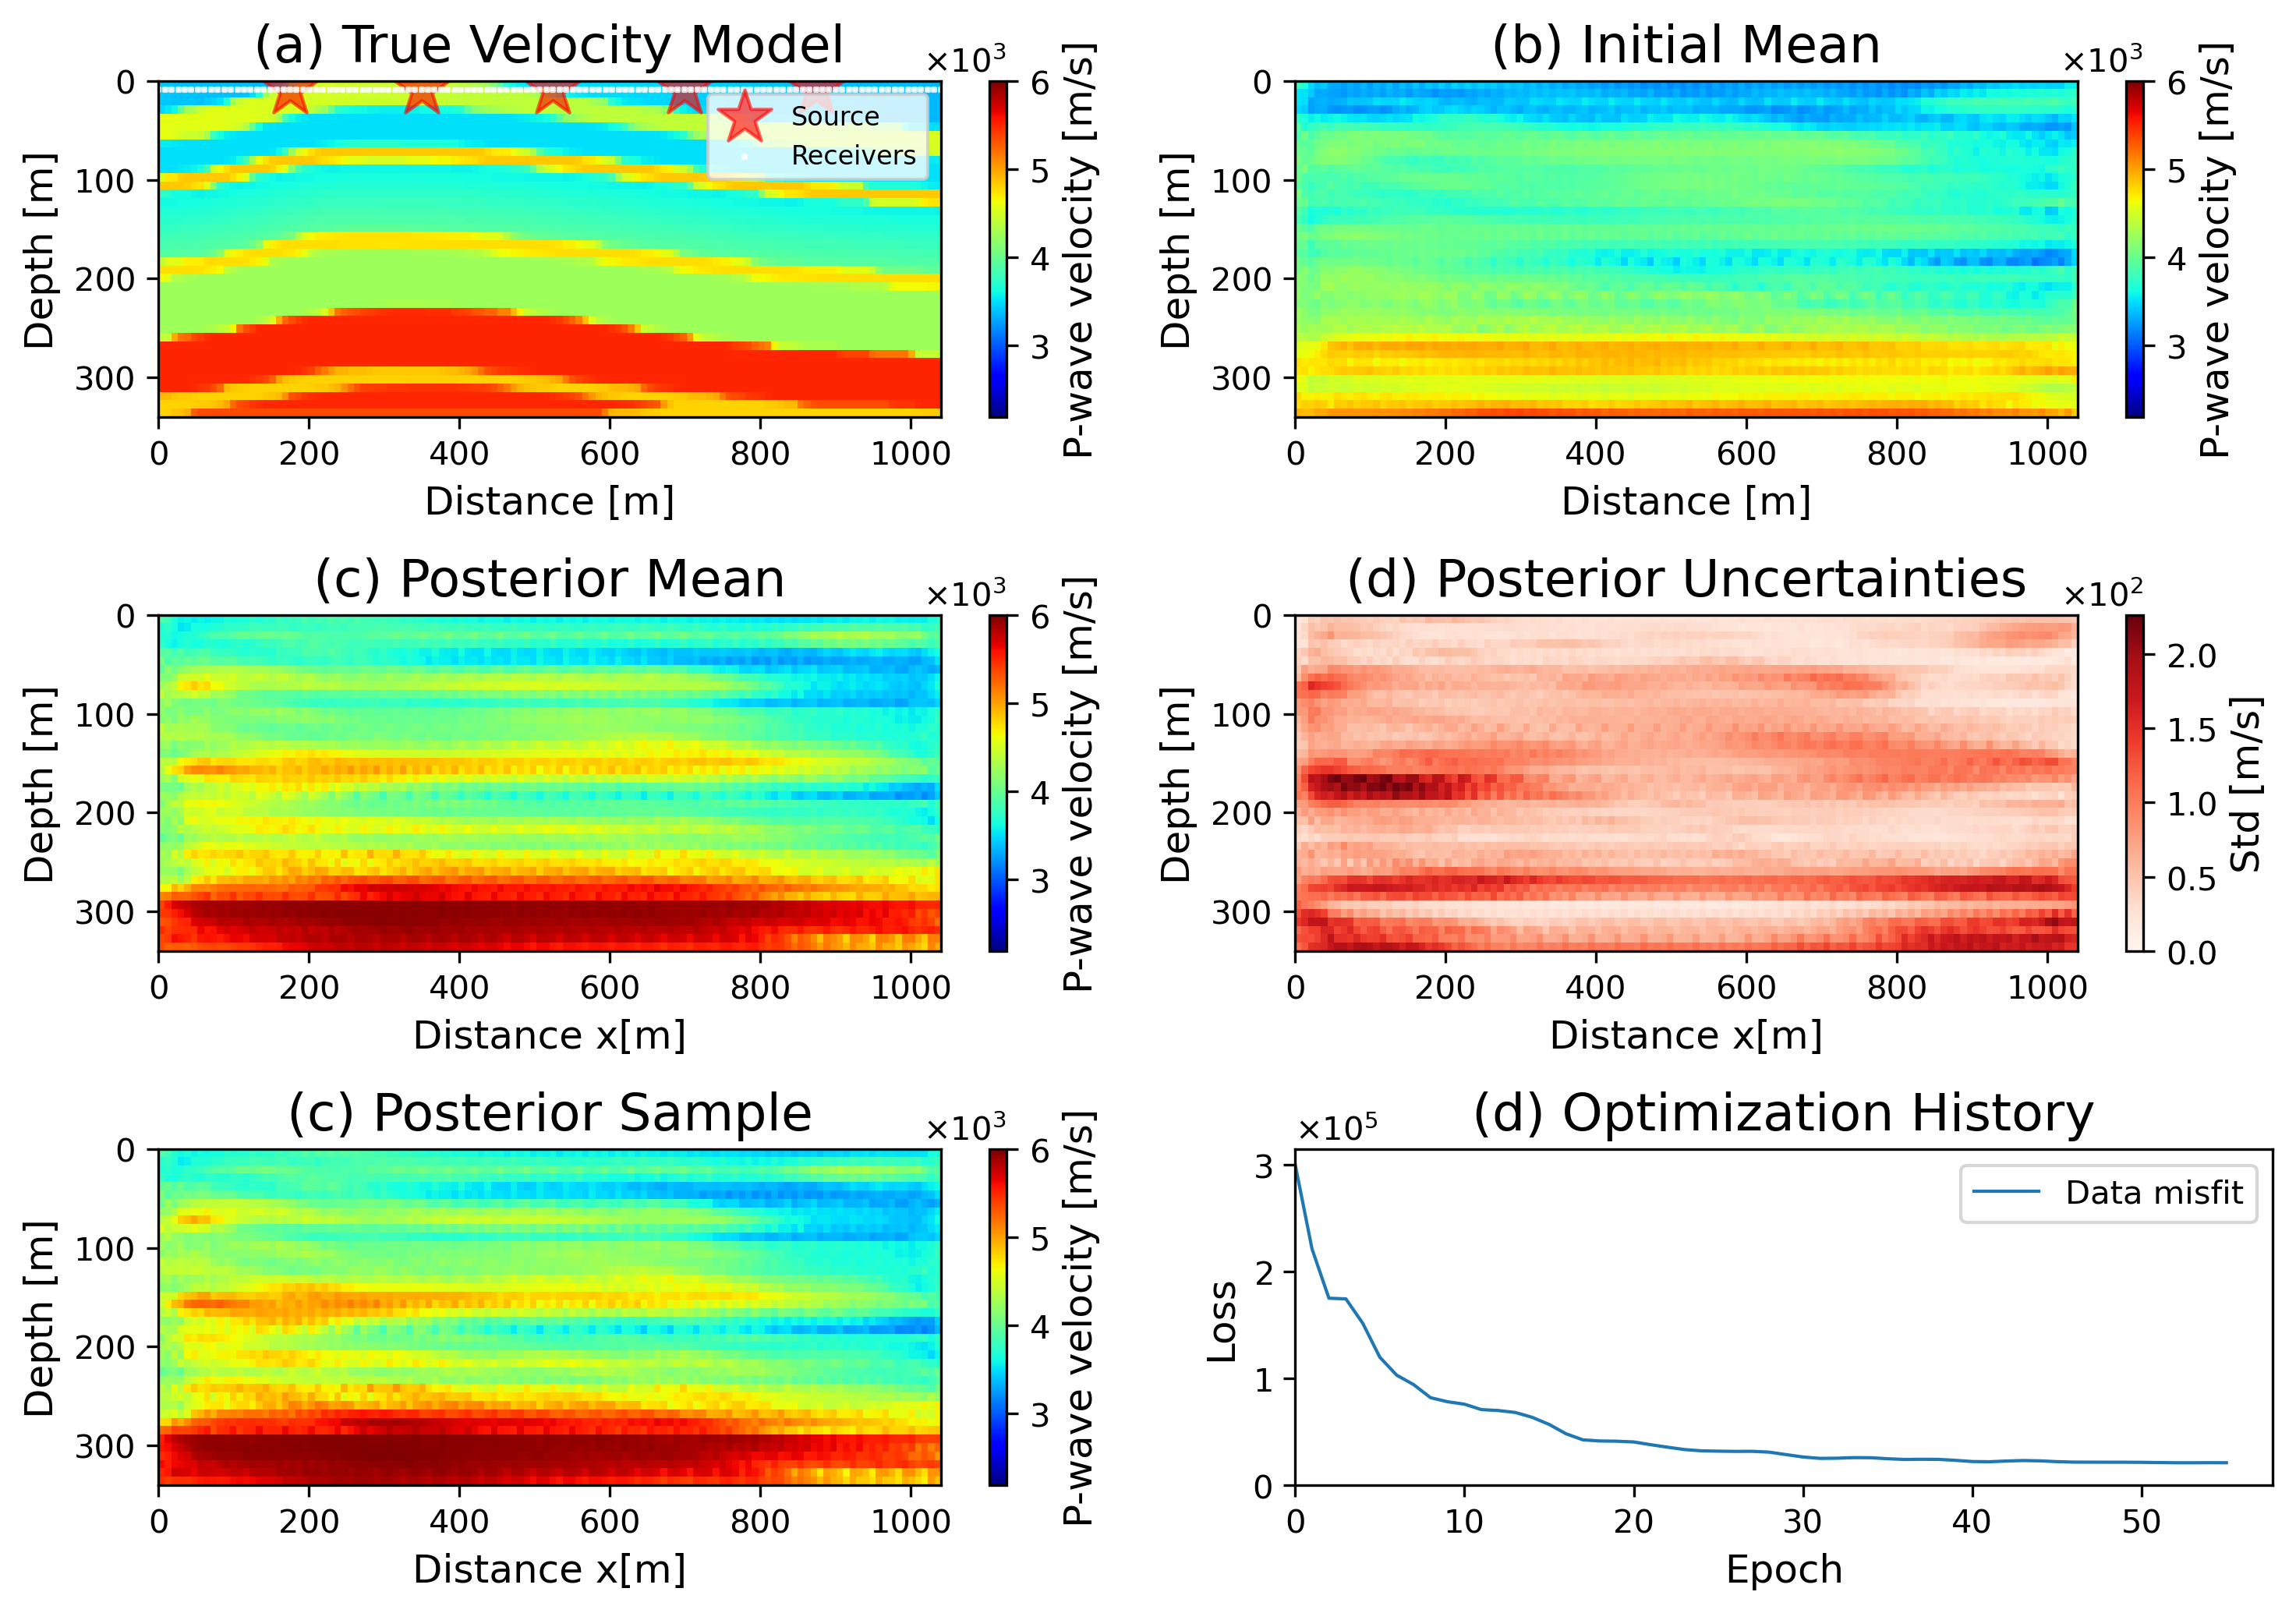

KeyboardInterrupt: 

In [77]:
def plot_loss(epoch_vels, loss_list):
    # Display current velocity field
    clear_output(wait=True)
    print('Iteration', int(i))

    plt.figure(figsize=(10,7), dpi=300)
    # Plot the true velocity
    plt.subplot(321)
    plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
    plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
    plt.legend(loc='upper right',fontsize=labelsize-8)
    plt.xlabel('Distance [m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(a) True Velocity Model",fontsize=labelsize)

    # Plot the initial velocity
    plt.subplot(322)
    plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance [m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(b) Initial Mean",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(323)
    plt.imshow(post_mean.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) Posterior Mean",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(324)
    plt.imshow(post_std.numpy().reshape((nz,nx)),vmin=0,cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("Std [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(d) Posterior Uncertainties",fontsize=labelsize)

    # Plot the velocity field at current iteration
    plt.subplot(325)
    plt.imshow(epoch_vels[0].numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
    cbar = plt.colorbar()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_scientific(True)
    cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
    cbar.update_ticks()
    cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
    plt.xlabel('Distance x[m]', fontsize=labelsize-4)
    plt.ylabel('Depth [m]', fontsize=labelsize-4)
    plt.title("(c) Posterior Sample",fontsize=labelsize)

    # Display loss track
    plt.subplot(326)
    plt.plot(loss_list,lw=1)
    # Set the x-axis tick formatter to scientific notation
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(['Data misfit'])
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.xlabel('Epoch', fontsize=labelsize-4)
    plt.ylabel('Loss', fontsize=labelsize-4)
    plt.title("(d) Optimization History",fontsize=labelsize)

    plt.tight_layout()
    plt.show()

def kth_nearest_neighbors(X, k):
    # Find the indices of the k-th nearest neighbors for each sample
    # distances: A tensor of pairwise distances (M, M)
    # k: The value of k for the k-th nearest neighbor
    M = X.shape[0]
    distance = []
    for i in range(M):
        dist_i = tf.sqrt(tf.reduce_sum((X - X[i,:])**2, axis=1))
        log_rho_i = tf.math.log(tf.sort(dist_i)[k+1])
        distance.append(log_rho_i)
    return dim_z * tf.reduce_mean(log_rho_i)

cond_generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Pass noise through Inference Network I
noise_w = tf.random.normal([BATCH_SIZE, dim_w])
# Kozachenko-Leonenko estimator: k = sqrt(M)
k = int(np.round(np.sqrt(dim_z)))

for i in range(1000):
  # grad = tape.gradient(J, v_gan)
  with tf.GradientTape(persistent=True) as tape:
    noise_z = inference_network(noise_w, training=False)
    epoch_losses = []
    epoch_vels = []
    for i in range(BATCH_SIZE):
      print('.',end='')
      noise_z_i = noise_z[i:i+1,:]
      # Generate image from I(w)
      Gz = cond_generator(noise_z_i, training=False)
      Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
      m = tf.reshape(Gz, -1)
      # Forward propagation & Adjoint back propagation
      J = dJ_dm(m)
      neg_log_post = J + tf.reduce_sum(noise_z_i**2) * sigma**2
      # Save generated velocity fields and loss
      epoch_vels.append(m)
      epoch_losses.append(neg_log_post)

    # Compute Posterior Mean velocity
    post_mean = tf.reduce_mean(epoch_vels,axis=0)
    post_std = tf.math.reduce_std(epoch_vels,axis=0)
    
    # Negative Entropy loss
    entropy = kth_nearest_neighbors(noise_z, k) 
    # Compute averate loss of this epoch's batch
    epoch_loss = tf.reduce_mean(epoch_losses) - entropy

  # Save loss
  loss_tracker.append(epoch_loss)  
  plot_loss(epoch_vels, loss_tracker)
  
  # Compute gradient of loss w.r.t.  
  grad = tape.gradient(epoch_loss, inference_network.trainable_variables)
  # print('Sum of dJ|dw',sum([tf.reduce_sum(tf.abs(g)) for g in grad]).numpy())
  cond_generator_optimizer.apply_gradients(zip(grad, inference_network.trainable_variables))

## Posterior Samples

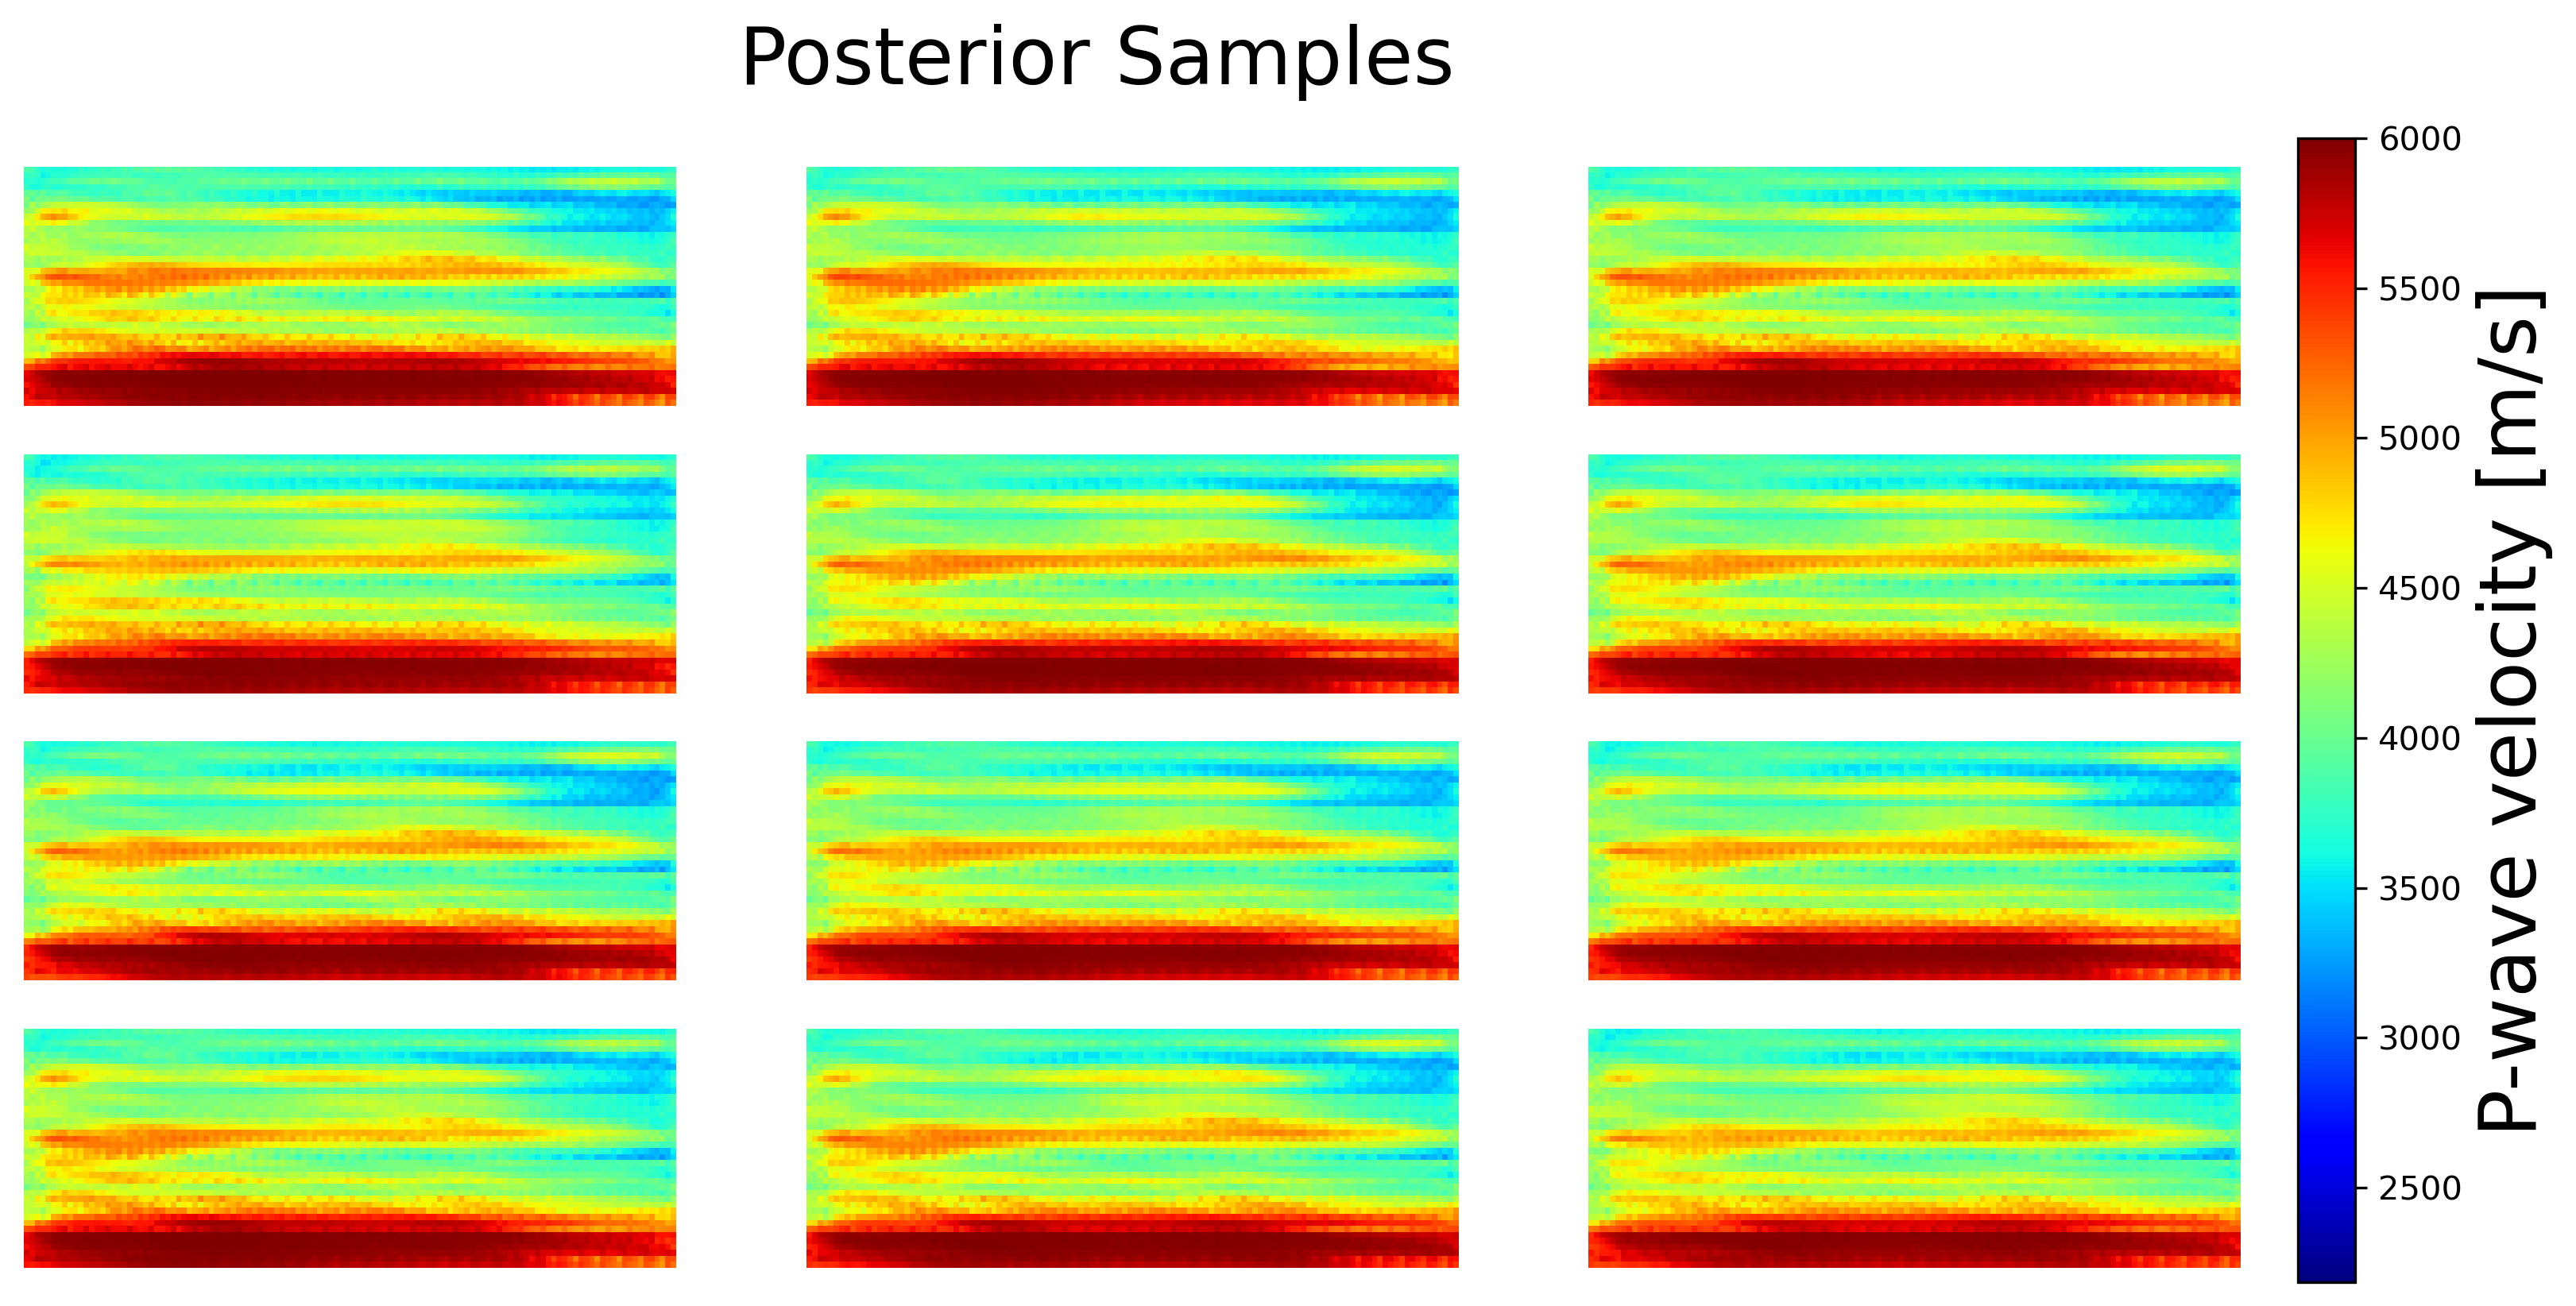

In [68]:
fig = plt.figure(figsize=(12, 6),dpi=300)
plt.suptitle("Posterior Samples", fontsize=24)
for k in range(12):
  plt.subplot(4, 3, k+1)
  plt.imshow(epoch_vels[k].numpy().reshape((nz,nx)),cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=24)
plt.show()